In [86]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)    # modify ylims to focus on region of interest

In [38]:
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y


---
## **Maps of event**

### **MODIS active fires**

In [45]:
sf = gpd.read_file("sf_hfr").to_crs(cproj)

In [46]:
fires = pd.concat([gpd.read_file(fnm) for fnm in glob.glob("firms/sf_modis-*")]).to_crs(cproj)
fires["y"] = [int(d[:4]) for d in fires.ACQ_DATE]
fires["m"] = [int(d[5:7]) for d in fires.ACQ_DATE]

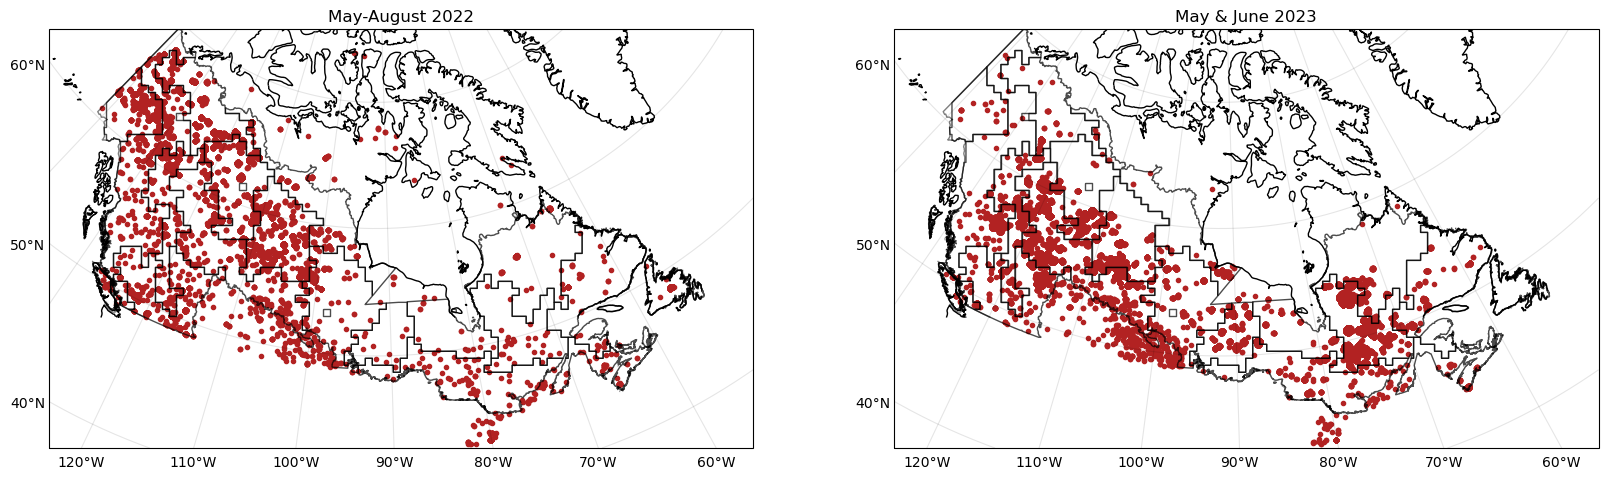

In [88]:
fig, axs = plt.subplots(ncols = 2, figsize = (20,9), dpi = 100, subplot_kw = {"projection" : cproj})

for i in range(2):
    
    Y = range(2022,2024)[i]
    fires.loc[[y == Y for y in fires.y]].plot(ax = axs[i], marker = ".", color = "firebrick")
    axs[i].set_title("May & June "+str(Y))

axs[0].set_title("May-August 2022")
for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"], xlocs = range(-140,-50,10), ylocs = range(40,90,10))
    
    sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)
    
    ax.set_xlim(*cproj.bounds[:2])
    ax.set_ylim(*cproj.bounds[2:])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


(750000.0, 4340847.387925235)

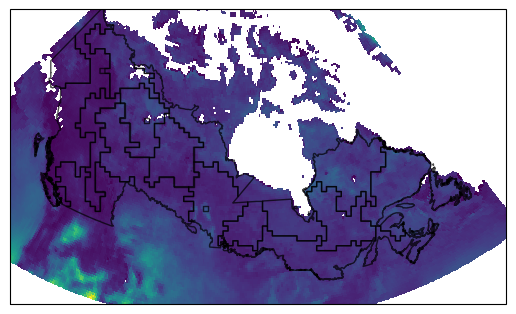

In [90]:
da = xr.open_dataset("data/percentile_99_map.nc").fwi
x,y = latlon_to_lambert(da)

fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
ax.pcolormesh(x,y,da)

sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.7)

ax.set_xlim(*cproj.bounds[:2])
ax.set_ylim(*cproj.bounds[2:])

#### **Fires per HFR**

In [6]:
zz = gpd.overlay(fires, sf, how='intersection')

In [8]:
zz

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,...,BRIGHT_T31,FRP,DAYNIGHT,TYPE,y,m,grid60km_n,NAMES,NAMES_SHOR,geometry
0,58.70760,-118.66290,302.60,1.40,1.20,2005-05-01,0458,Terra,MODIS,50,...,270.20,17.80,N,0.0,2005,5,15.0,Southern Prairies zone,SP,POINT (4731953.510 2807101.830)
1,53.36670,-106.25470,304.90,1.00,1.00,2005-05-01,1827,Terra,MODIS,60,...,285.70,6.20,D,0.0,2005,5,15.0,Southern Prairies zone,SP,POINT (5264274.863 2017337.098)
2,53.36270,-106.17420,302.70,1.10,1.00,2005-05-01,1827,Terra,MODIS,53,...,285.00,4.80,D,0.0,2005,5,15.0,Southern Prairies zone,SP,POINT (5269323.460 2015728.495)
3,53.37160,-106.17000,304.80,1.10,1.00,2005-05-01,1827,Terra,MODIS,60,...,285.90,6.00,D,0.0,2005,5,15.0,Southern Prairies zone,SP,POINT (5269809.674 2016618.488)
4,53.51050,-106.26430,301.00,1.00,1.00,2005-05-01,1827,Terra,MODIS,41,...,283.50,5.00,D,0.0,2005,5,15.0,Southern Prairies zone,SP,POINT (5267199.430 2032842.981)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207613,51.13742,-90.93245,414.20,1.03,1.01,2023-06-28,1919,Aqua,MODIS,100,...,288.58,0.00,D,NaN,2023,6,9.0,Western Ontario zone,WO,POINT (6264877.899 1666269.350)
207614,51.16905,-90.76195,317.55,1.04,1.02,2023-06-28,1919,Aqua,MODIS,51,...,293.80,10.60,D,NaN,2023,6,9.0,Western Ontario zone,WO,POINT (6276656.759 1669950.075)
207615,51.13946,-90.94543,323.66,1.65,1.26,2023-06-29,0258,Terra,MODIS,100,...,278.68,46.11,N,NaN,2023,6,9.0,Western Ontario zone,WO,POINT (6263973.288 1666481.375)
207616,53.82305,-88.82411,308.68,1.18,1.08,2023-06-29,1626,Terra,MODIS,37,...,281.13,8.23,D,NaN,2023,6,9.0,Western Ontario zone,WO,POINT (6397102.567 1965780.718)


<AxesSubplot: >

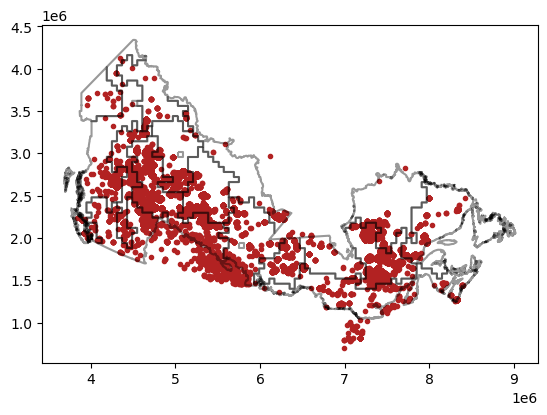

In [111]:
sf.boundary.plot(color = "k", alpha = 0.4)
fires.loc[[y == 2023 for y in fires.y]].plot(ax = plt.gca(), marker = ".", color = "firebrick")


### **fwi7x**

In [ ]:
# monthly maxima of 7-day average of FWI
fwi7x = fwi.rolling(time = 7).mean().resample(time = "MS").max()

### **fwiq99**

In [19]:
fwi99_mj = fwi.sel(time = [m in [5,6] for m in fwi.time.dt.month]).resample(time = "AS-DEC", label = "right").quantile(0.99)
fwi99_mj = fwi99_mj.assign_attrs(note = "99th percentile of FWI during May and June in each grid cell")
fwi99_mj.to_netcdf("data/fwi99-mj_era5_1941-2023")

In [15]:
fwi99_mj.isel(time = slice(-5,None)).plot(col = "time", vmax = 20, vmin = 0, cmap = "inferno")

In [34]:
sf = gpd.read_file("sf_hfr").to_crs(cproj)

da = xr.open_dataset("data/percentile_99_map.nc").fwi
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.longitude, da.latitude).sel(region = 3).reset_coords(drop = True)

Text(0.5, 1.0, '99th percentile of FWI during May-June 2023 (ERA5)')

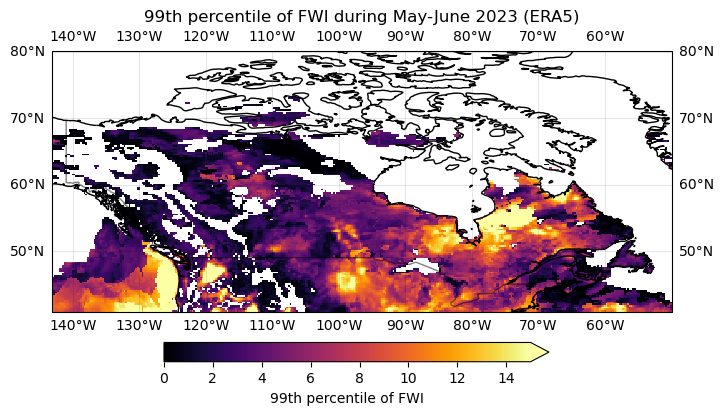

In [21]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

fwi99_mj.isel(time = -1).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 1.0, '99th percentile of FWI during May-June 2023 (ERA5)')

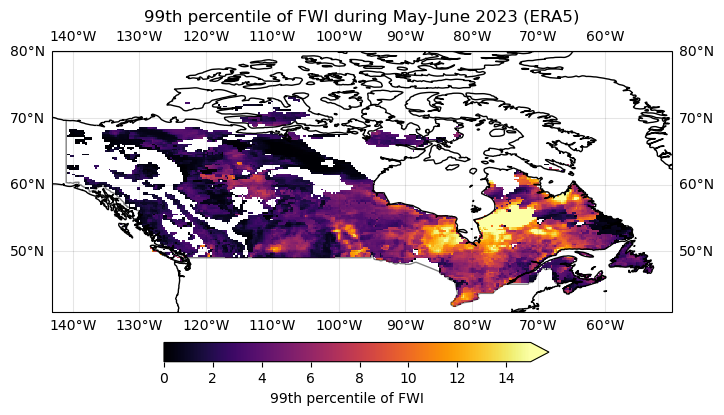

In [35]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

fwi.sel(time = slice("2023-05", "2023-06")).quantile(0.99, "time").where(rm).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

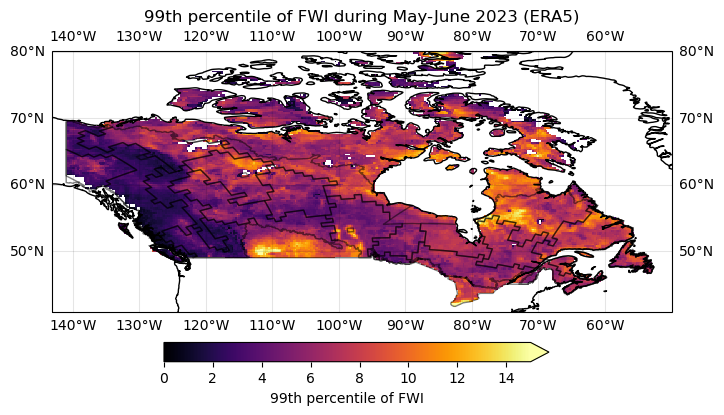

In [36]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})

da.where(rm).plot(ax = ax, cmap = "inferno", cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "label" : "99th percentile of FWI", "pad" : 0.08}, vmin = 0, vmax = 15)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5)
ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("99th percentile of FWI during May-June 2023 (ERA5)")

sf.boundary.plot(ax = ax, lw = 1, color = "k", alpha = 0.5)

# [ax.annotate(text = v.NAMES_SHOR, xy = (v.geometry.representative_point().x, v.geometry.representative_point().y)) for k,v in sf.iterrows()]

plt.savefig("fig/fwi99-map.png")

### **MODIS active fires**

In [4]:
df = pd.read_csv("data/modis_2022_Canada.csv")
df_mj = df[(df.acq_date >= "2022-05-01") & (df.acq_date <= "2022-06-30")]

Text(0.5, 1.0, 'Active fires recorded during May-June 2022 (MODIS)')

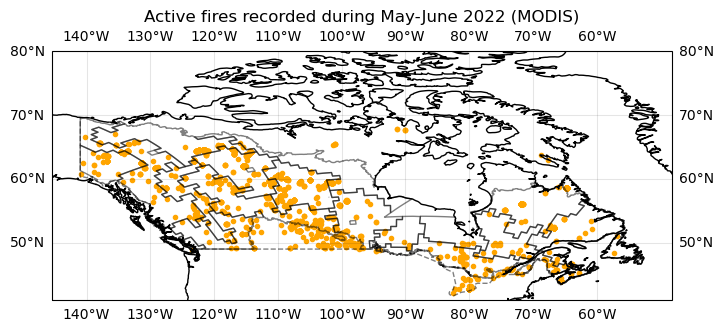

In [5]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100, subplot_kw = {"projection" : cproj})
ax.coastlines(color = "k")
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5, color = "k")
sf.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)

ax.scatter(df_mj.longitude, df_mj.latitude, marker = ".", color = "orange")
ax.set_ylim(41,80.1)

ax.gridlines(color = "k", alpha = 0.1, draw_labels = True, xlocs = range(-140,-50,10), ylocs = range(40,90,10))
ax.set_title("Active fires recorded during May-June 2022 (MODIS)")


### **MODIS burned area data**

In [ ]:
# sftp fire@fuoco.geog.umd.edu (password: burnt)

# get /data/MODIS/C61/MCD64A1/HDF/h11v04/MCD64A1.A2023*

# h = 10-14; v = 2-4; days 121 and 152

In [ ]:
import rioxarray as rxr, xarray as xr
import glob, re
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy
import numpy as np

def transform_xy(x, y, crs_in = None, crs_out = None):
    
    # transform 1d or 2d coords into 2d coords in another projection
    
    x = np.array(x)
    y = np.array(y)
    
    if x.ndim == 1:
        # tile 1d coordinates into 2d arrays of x, y per cell
        x_2d = np.tile(np.array(x), (len(y), 1))
        y_2d = np.tile(np.array([y]).transpose(), (1, len(x)))
    else:
        # coordinates are already 2d arrays
        x_2d = x
        y_2d = y
    
    if crs_in is None or crs_out is None:
        # return tiled points on original grid
        return x_2d, y_2d
        
    else:
        # transform and return
        xy_transf = crs_out.transform_points(crs_in, x_2d, y_2d)
        return xy_transf[:,:,0], xy_transf[:,:,1]

sf = gpd.read_file("sf_hfr").to_crs(cartopy.crs.PlateCarree())

In [ ]:
# d = "2022152"
# da = xr.concat([xr.concat([rxr.open_rasterio(glob.glob("modis/*"+d+".h"+h+"v"+v+"*.hdf")[0])
#                            for h in [str(h).rjust(2, "0") for h in range(10,15)]], "x")
#                 for v in [str(v).rjust(2, "0") for v in range(2,5)]], "y").squeeze(drop = True)
# lons, lats = transform_xy(da.x, da.y, crs_in = cartopy.crs.Sinusoidal(), crs_out = cartopy.crs.PlateCarree())
# da = da.assign_coords(lon = (["y", "x"], lons), lat = (["y", "x"], lats))
# da.to_netcdf("data/modis_"+d+".nc")

In [ ]:
da = xr.open_dataset("data/modis_2022121.nc")

In [ ]:
da["Burn Date"].plot()

In [ ]:
da["Burn Date"].where(da["Burn Date"] >= 0).plot()

In [ ]:
fig, ax = plt.subplots(ncols = 1, figsize = (8,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
ax.pcolormesh(lons, lats, da["Burn Date"].squeeze())
sf.boundary.plot(ax = ax, color = "k")